In [1]:
%pip install tensorflow==2.18.0 tensorflow-hub==0.16.1


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# 1. Setup
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
# 2. Paths
DATA_DIR = "../data/PlantVillage"  

In [4]:
# 3. Parameters
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SEED = 123

Train the model by incorporating only tomatoes and potatoes in the data

In [ ]:
# 4. Filter the data by tomatoes and potatoes

all_classes = sorted([
    d for d in os.listdir(DATA_DIR)
    if os.path.isdir(os.path.join(DATA_DIR, d))
])

Necessary_classes = [cls for cls in all_classes if cls.startswith(("Tomato", "Potato"))]

In [22]:
# 5. Load the Dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    labels='inferred',
    label_mode='categorical',
    class_names=Necessary_classes
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    labels='inferred',
    label_mode='categorical',
    class_names=Necessary_classes
)

Found 18163 files belonging to 13 classes.
Using 14531 files for training.
Found 18163 files belonging to 13 classes.
Using 3632 files for validation.


In [ ]:
# 6. Class names - Tomatoes and potatoes only
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Detected classes: {class_names}")

Detected classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [24]:
# 7. Optimize input pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [25]:
# 8. Data normalization
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [26]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
base_model.trainable = False  # Freeze base

inputs = tf.keras.Input(shape=(224, 224, 3))
x = normalization_layer(inputs)
x = base_model(x, training=False)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', #replaced the sparse_categorical_crossentropy 
    metrics=['accuracy']
)

In [27]:
# 10. Train Model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 106s 230ms/step - accuracy: 0.6938 - loss: 0.9466 - val_accuracy: 0.8744 - val_loss: 0.3839
Epoch 2/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 118s 259ms/step - accuracy: 0.8740 - loss: 0.3669 - val_accuracy: 0.8753 - val_loss: 0.3626
Epoch 3/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 137s 301ms/step - accuracy: 0.9088 - loss: 0.2638 - val_accuracy: 0.9020 - val_loss: 0.2966
Epoch 4/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 138s 304ms/step - accuracy: 0.9280 - loss: 0.2117 - val_accuracy: 0.9144 - val_loss: 0.2470
Epoch 5/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 139s 306ms/step - accuracy: 0.9403 - loss: 0.1736 - val_accuracy: 0.9127 - val_loss: 0.2535
Epoch 6/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 259s 570ms/step - accuracy: 0.9478 - loss: 0.1435 - val_accuracy: 0.9116 - val_loss: 0.2689
Epoch 7/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 251s 553ms/step - accuracy: 0.9549 - loss: 0.1277 - val_accuracy: 0.9163 - val_loss: 0.2652
Epoch 8/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 230s 505ms/step - accuracy: 0.9639 -

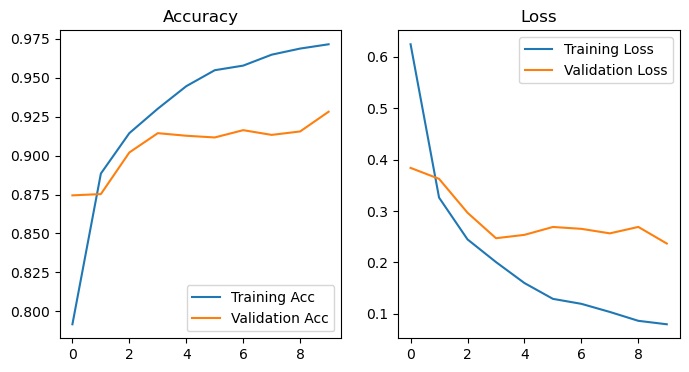

In [28]:
# 11. Plot Accuracy & Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Acc')
plt.plot(epochs_range, val_acc, label='Validation Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [29]:
# 12. Save Model
model.save("model/tomato&potato_disease_classifier.h5")